# Loan Recommendation System
## POC - Proof Of Concept

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, countDistinct, count
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
from pyspark.sql.functions import mean
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, DenseMatrix
from pyspark.ml import Pipeline 

In [3]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "2g").getOrCreate()

In [5]:
spark

In [6]:
loans_df = spark.read.csv("Loan_Dataset/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



- Id: Likely a unique identifier for each data point.
- AccountID: Unique identifier for an account (possibly borrower).
- <h4>Loan-related features: </h4> 
    -> Number_Of_Loans_Granted__c: Number of loans granted to the account.
    -> Num_Of_Loans_Paid__c: Number of loans paid by the account.
    -> Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    -> Total_Repayments__c: Total amount repaid by the account.
    -> Amount: Loan amount requested.
    -> Term_in_Weeks__c: Loan term in weeks.
    -> Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
- <h4>Borrower-related features: </h4>    -> 
StageName: Current stage of the loan application (e.g., application, approved, rejected).    -> 
Applicant Age: Age of the loan applicant    -> .
summary_income: Summary of applicant's incom    -> e.
summary_income_cv: Coefficient of variation of applicant's inco- <h4>me.
Location-related feat </h4>u    -> res:
city: City of the appli    -> cant.
state: State of the appl    -> icant.
Country: Country of the ap

- <h4>Additional features:</h4>    -> 
userId: Unique identifier for a user Account Id in Numericr).    -> 
loanId: Unique identifier for a lo (Id or loanId in Numeric)an    -> .
counFeature related to the Ratings of the Loansnt    -> s.
LoanIdFormat: Format of the loan(Created LoanId using Clusters)nce).plicant.

In [7]:
loans_df.select(["LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+------------+------+-------------------+--------------------+-----+
|LoanIdFormat|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+------------+------+-------------------+--------------------+-----+
|           1|   500|                 10|              Weekly|    3|
|           1|   700|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   900|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
+------------+------+-------------------+--------------------+-----+
only showing top 10 rows



In [8]:
loans_df.select(["userId","LoanIdFormat","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|summary|            userId|      LoanIdFormat|             count|           Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|  count|            559151|            559151|            559151|           559151|             559151|                    559151|              559151|
|   mean|24735.774815747445| 4.527168868516734|1.6699120631099649|823.7755990778877| 7.0393507299459355|        11.901447015206983|   11.85676856519974|
| stddev|15283.929730968575|2.7984778294163046|0.8954014280676444|766.2637755312196| 3.9631196080149786|         8.154409123854771|   8.273339043377455|
|    min|                 1|                 1|                 0|              10

In [9]:
loans_df.show(vertical=True)

-RECORD 0------------------------------------------
 Id                         | 0062x00000DsEQcAAN   
 AccountID                  | 0010K00001ayVHPQA2   
 Number_Of_Loans_Granted__c | 27                   
 Num_Of_Loans_Paid__c       | 27                   
 Purpose_of_Loan__c         | Furniture or Appl... 
 Total_Repayments__c        | 10                   
 Amount                     | 500                  
 Term_in_Weeks__c           | 10.143               
 Payment_Frequency__c       | Weekly               
 StageName                  | Loan Paid            
 Applicant Age              | 55                   
 summary_income             | 2166.67              
 summary_income_cv          | 5750.7               
 city                       | Jimboomba            
 state                      | QLD                  
 Country                    | Australia            
 userId                     | 1                    
 loanId                     | 385865               
 count      

In [10]:
hist_data  = loans_df.toPandas()

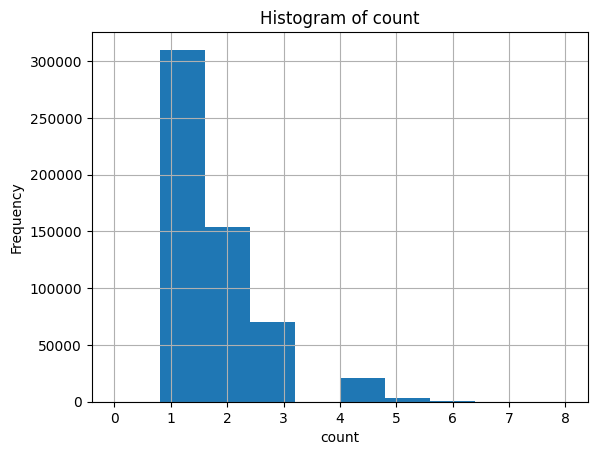

In [11]:
hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

In [12]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('LoanIdFormat').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 20
Number of unique Loan Id: 407389


In [13]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

# Count the number of unique users
# tmp = ratings_df.select('movieId').distinct().count()
# print(f"Number of unique movies: {tmp}")

Number of unique users: 59158


In [153]:
print('Distinct values of count:')
print(sorted(loans_df.select('count').distinct().collect()))

Distinct values of count:
[Row(count=0), Row(count=1), Row(count=2), Row(count=3), Row(count=4), Row(count=5), Row(count=6), Row(count=7), Row(count=8)]


In [14]:
# distinct values of the rating
loans_df.select("count").distinct().show()

+-----+
|count|
+-----+
|    1|
|    6|
|    3|
|    5|
|    4|
|    8|
|    7|
|    2|
|    0|
+-----+



========================================================================================================

Converting the dataset into train test and validation split.

In [15]:
loans_df.select(["LoanIdFormat","count","Amount"]).show(10)

+------------+-----+------+
|LoanIdFormat|count|Amount|
+------------+-----+------+
|           1|    3|   500|
|           1|    3|   700|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   900|
|           1|    3|  1000|
|           1|    3|  1000|
+------------+-----+------+
only showing top 10 rows



In [16]:
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, LoanIdFormat: int]

In [17]:
validation.select(["userId","loanId","LoanIdFormat","count","Amount","Total_Repayments__c"]).show()

+------+------+------------+-----+------+-------------------+
|userId|loanId|LoanIdFormat|count|Amount|Total_Repayments__c|
+------+------+------------+-----+------+-------------------+
| 25117|    33|           1|    3|   650|                 10|
| 23515|    37|           1|    3|   700|                 10|
| 23556|   133|           1|    1|  1000|                 10|
| 25300|   194|           1|    2|   200|                 10|
|    74|   230|           1|    3|   350|                 10|
| 24945|   286|           1|    1|   500|                 10|
| 24534|   307|           1|    3|   500|                 10|
| 24205|   332|           1|    3|   200|                 10|
|   189|   334|           1|    1|   500|                 10|
| 23435|   364|           1|    2|   250|                 10|
| 24703|   370|           1|    4|   900|                 10|
| 23545|   376|           1|    4|   400|                 10|
| 23845|   429|           1|    3|   700|                 10|
| 23505|

In [18]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [19]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='LoanIdFormat', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)
            
            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))
            
            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)
            
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [20]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.028842204161434074
8 latent factors and regularization = 0.01: validation RMSE is 0.05103586511811166
8 latent factors and regularization = 0.05: validation RMSE is 0.08461358200186672
8 latent factors and regularization = 0.1: validation RMSE is 0.10687898611747992
8 latent factors and regularization = 0.2: validation RMSE is 0.19912760105738467
10 latent factors and regularization = 0.001: validation RMSE is 0.12544393880094343
10 latent factors and regularization = 0.01: validation RMSE is 0.03563578960947876
10 latent factors and regularization = 0.05: validation RMSE is 0.07662848615347416
10 latent factors and regularization = 0.1: validation RMSE is 0.09651748740437144
10 latent factors and regularization = 0.2: validation RMSE is 0.1987478862479139
20 latent factors and regularization = 0.001: validation RMSE is 0.059609877840866486
20 latent factors and regularization = 0.01: validation RMSE is 0.034506377814182

In [21]:
#OLD :  40 latent factors and regularization = 0.001
#NEW: The best model has 8 latent factors and regularization = 0.001

## Predicting the results from validation data

In [22]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [114]:
predictions.filter(predictions.userId == 10).select("userId", "loanId", "count", "LoanIdFormat", "prediction").show(20)

+------+------+-----+------------+----------+
|userId|loanId|count|LoanIdFormat|prediction|
+------+------+-----+------------+----------+
|    10|248485|    4|           1| 3.9935606|
|    10|371513|    4|           1| 3.9935606|
|    10| 10615|    4|           6| 3.9546485|
|    10| 23209|    4|           6| 3.9546485|
|    10|383859|    4|           2|  3.991086|
+------+------+-----+------------+----------+



In [150]:
predictions.count()

111352

In [151]:
validation.count()

111877

## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [23]:
 
# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))


Root Mean Squared Error (RMSE) = 0.028842204161434074


## Recommendation of N users

In [122]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [126]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [130]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



## ALS Model Evaluation

In [ ]:
from pyspark.sql.functions import col, expr

In [138]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['userId', 'LoanIdFormat'], 'inner')

In [142]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('userId').agg(expr('count(LoanIdFormat) as true_positives'))

In [144]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('userId').agg(expr('count(LoanIdFormat) as relevant'))

In [145]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as precision')

In [146]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as recall')

In [147]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'userId', 'inner') \
    .selectExpr('userId', '(2 * precision * recall) / (precision + recall) as f1_score')

In [148]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [149]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 1.8466075417340844
Overall Recall: 1.8466075417340844
Overall F1-score: 1.8466075417340917


## User Factors and Item Factors to calculate the cosine Similarity

In [ ]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [26]:
final_model.userFactors.orderBy("id").collect()

[Row(id=1, features=[4.158053398132324, 2.334045648574829, 0.005036159418523312, 4.159778594970703, 1.981391429901123, 3.1190431118011475, 2.4070258140563965, 0.009476770646870136]),
 Row(id=2, features=[2.838655948638916, 1.4919605255126953, 0.0, 2.681072473526001, 1.4392510652542114, 2.1257224082946777, 1.5806996822357178, 0.0]),
 Row(id=3, features=[1.4075653553009033, 0.5733293294906616, 0.004282074980437756, 1.3201020956039429, 0.7914156317710876, 1.2892216444015503, 0.7133536338806152, 0.025837238878011703]),
 Row(id=4, features=[1.4584975242614746, 0.6837419271469116, 0.0, 1.3014748096466064, 0.767175555229187, 1.144400715827942, 0.7632264494895935, 0.0]),
 Row(id=5, features=[2.916995048522949, 1.3674838542938232, 0.0, 2.602949619293213, 1.534351110458374, 2.288801431655884, 1.526452898979187, 0.0]),
 Row(id=6, features=[1.455165147781372, 0.6823551654815674, 0.0, 1.2986465692520142, 0.76537024974823, 1.1416593790054321, 0.761584460735321, 0.0]),
 Row(id=7, features=[1.45516514

In [25]:
type(userFactors)

pyspark.sql.dataframe.DataFrame

In [27]:
userFactors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [166]:
userFactors.select(["id","Features"]).show(10,truncate=False)

+---+-----------------------------------------------------------------------------------------------+
|id |Features                                                                                       |
+---+-----------------------------------------------------------------------------------------------+
|10 |[5.7924514, 2.7759025, 0.0, 5.2189054, 3.0287783, 4.501434, 3.0662427, 0.0]                    |
|20 |[1.4584975, 0.6837419, 0.0, 1.3014748, 0.76717556, 1.1444007, 0.76322645, 0.0]                 |
|30 |[1.3727179, 0.778958, 0.0, 1.3981663, 0.6575755, 1.0415103, 0.8039331, 0.0]                    |
|40 |[1.4584975, 0.6837419, 0.0, 1.3014748, 0.76717556, 1.1444007, 0.76322645, 0.0]                 |
|50 |[1.3983066, 0.5676566, 0.0046561887, 1.3234804, 0.7887948, 1.294504, 0.7101965, 0.02809457]    |
|60 |[1.4568448, 0.6808848, 0.0, 1.2982739, 0.7669293, 1.1446061, 0.7611525, 0.0]                   |
|70 |[1.4584975, 0.6837419, 0.0, 1.3014748, 0.76717556, 1.1444007, 0.76322645, 0.0

## Calculate cosine similarity:

### user-User Cosine Similarity code 

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [57]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

In [58]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 10 and 20: 0.9999585467003842


### User-Item Cosine Similarity code

In [59]:
# Example usage
user1_id = 10
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")


Cosine similarity between users 10 and 1: 0.9974201391852973


###  Cosine Similarity of user 10 with all Loans

In [61]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]
    
    
    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [62]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 10, 'LoanId': 6, 'CosineSimilarity': 0.9999585465921065},
 {'userID': 10, 'LoanId': 1, 'CosineSimilarity': 0.9974201391852973},
 {'userID': 10, 'LoanId': 2, 'CosineSimilarity': 0.997024833969398},
 {'userID': 10, 'LoanId': 4, 'CosineSimilarity': 0.9963134193136397},
 {'userID': 10, 'LoanId': 8, 'CosineSimilarity': 0.996119009590138},
 {'userID': 10, 'LoanId': 9, 'CosineSimilarity': 0.9940790271396324},
 {'userID': 10, 'LoanId': 17, 'CosineSimilarity': 0.9934936842714687},
 {'userID': 10, 'LoanId': 15, 'CosineSimilarity': 0.9930037834538045},
 {'userID': 10, 'LoanId': 18, 'CosineSimilarity': 0.992891723903221},
 {'userID': 10, 'LoanId': 20, 'CosineSimilarity': 0.992753702092476},
 {'userID': 10, 'LoanId': 14, 'CosineSimilarity': 0.991944012100995},
 {'userID': 10, 'LoanId': 7, 'CosineSimilarity': 0.9918822377308257},
 {'userID': 10, 'LoanId': 12, 'CosineSimilarity': 0.9888173813712304},
 {'userID': 10, 'LoanId': 19, 'CosineSimilarity': 0.9360397202134642},
 {'userID': 10, 'L

##  Calculate centered cosine similarity:

In [43]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)
    
    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])
    
    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))
    
    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [44]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9998679429238302


### User-Item Centerd Cosine Similarity code

In [45]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.9915912910111744


### Cosine Similarity of user 10 with all Loans

In [53]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]
    
    
    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [54]:
# Import the operator module
import operator

In [55]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9998679425406234},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9915912910111744},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.990320020344896},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9880144133660409},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9876226904363},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9810484167854919},
 {'userID': 10, 'LoanId': 17, 'CenteredSimilarity': 0.9787237190274809},
 {'userID': 10, 'LoanId': 20, 'CenteredSimilarity': 0.9778946981767085},
 {'userID': 10, 'LoanId': 15, 'CenteredSimilarity': 0.9772770700181951},
 {'userID': 10, 'LoanId': 18, 'CenteredSimilarity': 0.976882421646373},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9746767268583482},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.9742615784378328},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9661985261736536},
 {'userID': 10, 'LoanId': 19, 'CenteredSimilarity': 0.804779911

In [65]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.9915912910111744},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.990320020344896},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.16685040969362763},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9880144133660409},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.7769802107920977},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9998679425406234},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9746767268583482},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9876226904363},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.9810484167854919},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': -0.3432629324345813},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.6093973622865452},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.9661985261736536},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': -0.2931643526928138},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.9742615

In [67]:
predictions.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [68]:
predictions.select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(11)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|           1|  1859|  2366|   500|                 10|    1| 0.9933492|
|           1| 18371|  4818|   600|                 10|    2| 1.9914738|
|           1| 24830|  1342|   500|                 10|    1| 0.9981674|
|           1| 39048|  1238|   500|                 10|    3|  2.984103|
|           1| 44319| 19984|   500|                  6|    3|  2.992899|
|           1| 44367| 16503|   300|                  6|    3| 2.9956226|
|           1| 44446| 15846|   200|                  6|    3|  2.991486|
|           1| 48006| 20683|   600|                 10|    1| 0.9933492|
|           1| 49432| 18866|   500|                  6|    1| 0.9981674|
|           1| 50698| 17420|   750|                 10|    1| 0.9965345|
|           1| 51505| 15447|   400|                

In [69]:
predictions.select("prediction","LoanIdFormat").describe().show()

+-------+------------------+------------------+
|summary|        prediction|      LoanIdFormat|
+-------+------------------+------------------+
|  count|            111352|            111352|
|   mean| 1.661863417419055| 4.518930957683741|
| stddev|0.8937703516935817|2.7881530111682316|
|    min|               0.0|                 1|
|    max|         7.9761477|                20|
+-------+------------------+------------------+



In [70]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
error = evaluator.evaluate(predictions)

In [71]:
print(f"The RMSE for the above m0odel is : {error}")  # o.463

The RMSE for the above mnodel is : 0.028842204161434074


In [98]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [99]:
loanRecommends.printSchema()

root
 |-- LoanIdFormat: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [100]:
loanRecommends.select(["LoanIdFormat","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

+------------+----------------------------------+-------------------------------------------------------+
|LoanIdFormat|userId                            |rating                                                 |
+------------+----------------------------------+-------------------------------------------------------+
|20          |[1832, 24495, 24531, 24991, 15933]|[7.950424, 7.0113587, 6.9573717, 6.0000634, 5.9925804] |
|10          |[1832, 24713, 24608, 24303, 24495]|[8.555681, 7.465768, 7.3844924, 7.339622, 7.0376883]   |
|1           |[1832, 24495, 24531, 15933, 24418]|[7.9761477, 7.0013914, 6.9772563, 6.0103855, 6.0089397]|
|11          |[1832, 24495, 24531, 15933, 24418]|[9.5949135, 8.382941, 8.35992, 7.275463, 7.274435]     |
|12          |[1832, 24495, 24531, 24991, 24301]|[7.973118, 7.0685134, 6.977419, 6.0400486, 6.019967]   |
|2           |[1832, 24495, 24531, 15933, 24418]|[7.9706793, 7.006312, 6.973244, 6.006671, 6.005226]    |
|13          |[1832, 24713, 24608, 24303, 2449

In [101]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [102]:
userRecommends.filter(userRecommends.userId == 10 ).show(vertical=True,truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------
 userId          | 10                                                                                
 recommendations | [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}] 



In [103]:
userRecommends.select(["userId","recommendations.LoanIdFormat","recommendations.rating"]).show(10,truncate=False)

+------+-------------------+--------------------------------------------------------+
|userId|LoanIdFormat       |rating                                                  |
+------+-------------------+--------------------------------------------------------+
|1     |[11, 19, 10, 5, 4] |[3.483842, 2.9951677, 2.9910934, 2.986418, 2.9808848]   |
|6     |[11, 19, 5, 10, 12]|[1.2100239, 1.0132257, 1.0107574, 1.0031507, 1.0014443] |
|12    |[11, 19, 5, 12, 10]|[2.4086132, 2.0269725, 2.0201576, 2.0100853, 2.0080824] |
|13    |[11, 19, 5, 10, 12]|[1.1989177, 1.0090533, 1.006838, 1.0012228, 0.99791485] |
|16    |[11, 19, 12, 5, 10]|[1.1825534, 1.0075336, 1.0040952, 1.0034789, 1.002596]  |
|22    |[11, 19, 5, 10, 1] |[1.1965677, 1.0075513, 1.0053955, 1.0006418, 0.99691176]|
|26    |[11, 19, 5, 10, 1] |[1.1896594, 1.0058196, 1.0035554, 0.99995625, 0.9963331]|
|27    |[11, 19, 5, 10, 1] |[1.1919556, 1.0058408, 1.0038042, 1.0001444, 0.99620336]|
|28    |[11, 10, 19, 5, 1] |[1.1703922, 0.99830914, 0.

In [105]:
LoanRecommendation =  [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}] 

In [106]:
loanRecommend_user_10 = [{"userID":10,"LoanId":loanI,"Ratings":ratin} for loanI,ratin in LoanRecommendation]

In [107]:
sorted(loanRecommend_user_10, key=operator.itemgetter('Ratings'),reverse=True )

[{'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896}]

In [109]:
loanRecommend_user_10

[{'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896},
 {'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12}]